In [53]:
from pathlib import Path
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
import pdb
import pickle
import numpy as np
from typing_extensions import Annotated

from BNS_JT import model, config, trans, variable, brc, branch, cpm, operation

HOME = Path().resolve()

%matplotlib inline

# The user input

In [54]:
key = 'od1'
thres = 5 # if it takes longer than this, we consider the od pair is disconnected

# Modelling

In [55]:
rnd_state = np.random.RandomState(1)

cfg = config.Config(HOME.joinpath('./config.json'))

od_pair = cfg.infra['ODs'][key]


scenario to be added later


In [56]:
# randomly assign probabilities
## Here we assume binary states for each edge, assuming that 
## connectivity is the most concerned factor for emergency activities.
probs_set = {0: {0: 0.05, 1: 0.95},
                1: {0: 0.15, 1: 0.85},
                2: {0: 0.30, 1: 0.70},
                }
probs_key = rnd_state.choice(3, size=len(cfg.infra['edges']))

# Here, we assume 
probs = {k: [probs_set[v][0], probs_set[v][1]]for k, v in zip(cfg.infra['edges'].keys(), probs_key)}

In [57]:
# variables
varis = {}
cpms = {}
for k, v in cfg.infra['edges'].items():
    varis[k] = variable.Variable(name=k, values = [np.inf, 1.0*v['weight']])
    cpms[k] = cpm.Cpm(variables = [varis[k]], no_child=1,
                        C = np.array([0, 1]).T, p = [probs[k][0], probs[k][1]])

In [58]:
comps_st_itc = {k: len(v.values) - 1 for k, v in varis.items()}

d_time_itc, _, path_itc = trans.get_time_and_path_given_comps(comps_st_itc, cfg.infra['G'], od_pair, varis)
print(d_time_itc)

893.0


In [59]:
G = cfg.infra['G']
all_paths = nx.all_simple_paths(G, od_pair[0], od_pair[1])

valid_paths = []

for path in all_paths:
    # Calculate the total weight of the path
    path_edges = [(u, v) for u, v in zip(path[:-1], path[1:])]
    path_weight = sum(G[u][v]['weight'] for u, v in path_edges)
    if path_weight < thres * d_time_itc:
        # Collect the edge names if they exist, otherwise just use the edge tuple
        edge_names = [G[u][v].get('key', (u, v)) for u, v in path_edges]
        valid_paths.append((path, edge_names, path_weight))

# Sort valid paths by weight
valid_paths = sorted(valid_paths, key=lambda x: x[2])

# Print the paths with edge names and weights
for path, edge_names, weight in valid_paths:
    print(f"Path (nodes): {path}")
    print(f"Path (edges): {edge_names}")
    print(f"Total weight: {weight}\n")

Path (nodes): ['Wooroloo', '0361', 'Merredin']
Path (edges): ['66', '67']
Total weight: 893

Path (nodes): ['Wooroloo', '4815', '4154', '4156', 'Merredin']
Path (edges): ['95', '96', '97', '98']
Total weight: 1342

Path (nodes): ['Wooroloo', '0289', '0288', '0287', '0286', '0285', '0284', '0283', '0282', '0281', '0280', '0279', '0278', '0277', 'Merredin']
Path (edges): ['76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89']
Total weight: 1442

Path (nodes): ['Wooroloo', '0752', '0753', '0754', '0761', '0762', '0763A', '0765', 'Merredin']
Path (edges): ['68', '69', '70', '71', '72', '73', '74', '75']
Total weight: 3251



In [60]:
path_names = []
for idx, (path, edge_names, weight) in enumerate(valid_paths):
    name = od_pair[0] + '_' + od_pair[1] + '_' + str(idx)
    path_names.append(name)

    varis[name] = variable.Variable(name=name, values = [np.inf, weight])

    n_edge = len(edge_names)

    # Event matrix of series system
    # Initialize an array of shape (n+1, n+1) filled with 1
    Cpath = np.ones((n_edge + 1, n_edge+1), dtype=int)
    # Fill the diagonal below the main diagonal with 0
    for i in range(1, n_edge + 1):
        Cpath[i, 0] = 0
        Cpath[i, i] = 0  
    # Fill the lower triangular part (excluding the diagonal) with 2
    for i in range(1, n_edge + 1):
        Cpath[i, i+1:] = 2
    ppath = np.array([1.0]*(n_edge+1))

    cpms[name] = cpm.Cpm(variables = [varis[name]] + [varis[e] for e in edge_names], no_child=1, C=Cpath, p=ppath)

print(cpms[name])


Cpm(variables=['Wooroloo_Merredin_3', '68', '69', '70', '71', '72', '73', '74', '75'], no_child=1, C=[[1 1 1 1 1 1 1 1 1]
 [0 0 2 2 2 2 2 2 2]
 [0 1 0 2 2 2 2 2 2]
 [0 1 1 0 2 2 2 2 2]
 [0 1 1 1 0 2 2 2 2]
 [0 1 1 1 1 0 2 2 2]
 [0 1 1 1 1 1 0 2 2]
 [0 1 1 1 1 1 1 0 2]
 [0 1 1 1 1 1 1 1 0]], p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [61]:
od_name = od_pair[0] + '_' + od_pair[1]
vals = [np.inf]
for p in path_names[::-1]:
    vals.append(varis[p].values[1])

n_path = len(path_names)
Csys = np.zeros((n_path+1, n_path+1), dtype=int)
for i in range(n_path):
    Csys[i, 0] = n_path - i
    Csys[i, i+1] = 1
    Csys[i, i+2:] = 2
psys = np.array([1.0]*(n_path+1))

varis[od_name] = variable.Variable(name=od_name, values = vals)
cpms[od_name] = cpm.Cpm(variables = [varis[od_name]] + [varis[p] for p in path_names], no_child=1, C=Csys, p=psys)

print(cpms[od_name])

Cpm(variables=['Wooroloo_Merredin', 'Wooroloo_Merredin_0', 'Wooroloo_Merredin_1', 'Wooroloo_Merredin_2', 'Wooroloo_Merredin_3'], no_child=1, C=[[4 1 2 2 2]
 [3 0 1 2 2]
 [2 0 0 1 2]
 [1 0 0 0 1]
 [0 0 0 0 0]], p=[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


Save the results

In [62]:
fcpms = cfg.output_path.joinpath('cpms.pk')
with open(fcpms, 'wb') as f:
    pickle.dump(cpms, f)

fvaris = cfg.output_path.joinpath('varis.pk')
with open(fvaris, 'wb') as f:
    pickle.dump(varis, f)

# Inference

Load data

In [63]:
cpms = pickle.load(open(fcpms, 'rb'))
varis = pickle.load(open(fvaris, 'rb'))
cfg = config.Config(HOME.joinpath('./config.json'))


scenario to be added later


## System event

In [64]:
od_pair = cfg.infra['ODs']['od1']

VE_ord = list(probs.keys()) + path_names
vars_inf = operation.get_inf_vars( cpms, od_name, VE_ord )


In [65]:
od_name = od_pair[0] + '_' + od_pair[1]

Mod = operation.variable_elim([cpms[k] for k in vars_inf], [v for v in vars_inf if v!=od_name]) 
print(Mod)

Cpm(variables=['Wooroloo_Merredin'], no_child=1, C=[[3]
 [2]
 [1]
 [0]
 [4]], p=[[0.24503587]
 [0.01481324]
 [0.05774588]
 [0.192405  ]
 [0.49      ]]


Visualisation

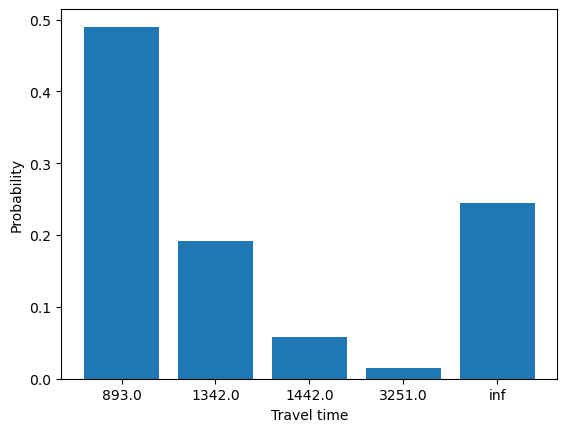

In [66]:
plt.figure()
p_flat = Mod.p.flatten()
plt.bar(range(len(p_flat)), p_flat[::-1], tick_label=varis[od_name].values[::-1])

plt.xlabel("Travel time")
plt.ylabel("Probability")

plt.show()

## Routes

In [67]:
paths_name = [v.name for v in cpms[od_name].variables[1:]]
print(paths_name)

['Wooroloo_Merredin_0', 'Wooroloo_Merredin_1', 'Wooroloo_Merredin_2', 'Wooroloo_Merredin_3']


In [68]:
paths_rel = []
for path_i in paths_name:
    VE_ord = list(probs.keys()) + path_names
    vars_inf = operation.get_inf_vars( cpms, path_i, VE_ord )

    Mpath = operation.variable_elim([cpms[k] for k in vars_inf], [v for v in vars_inf if v!=path_i]) 
    paths_rel.append( Mpath.p[1][0] )

print(paths_rel)

[0.48999999999999994, 0.4804624999999999, 0.05590659517797509, 0.23084421390624993]


Visualisation

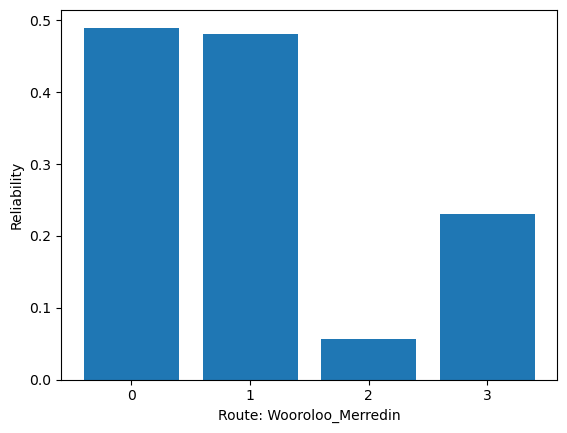

In [69]:
plt.figure()
p_flat = Mod.p.flatten()
plt.bar(range(len(paths_rel)), paths_rel, tick_label=range(len(paths_rel)))

plt.xlabel(f"Route: {od_name}")
plt.ylabel("Reliability")

plt.show()